<a href="https://colab.research.google.com/github/matthewpecsok/4482_fall_2022/blob/main/tutorials/Regression_and_regression_trees_insurance_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Regression and Regression Tree Tutorial

Adapted by Matthew Pecsok in June 2021 from Olivia Sheng's R tutorial 

(October 15, 2016)




# 1 Setup and Import Insurance dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

import statsmodels.api as sm
from scipy import stats
#from sklearn.metrics import 
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics

from sklearn.model_selection import cross_validate


In [ ]:
pd.options.display.float_format = '{:.2f}'.format # when creating means and std dev from our
# metrics we would get scientific notation without specifying this

## load the data

In [ ]:
insurance = pd.read_csv("https://raw.githubusercontent.com/matthewpecsok/4482_fall_2022/main/data/insurance.csv")

show column info

In [ ]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


show column statistics

In [ ]:
# include all makes sure to include categorical columns and makes it similar to summary in r
insurance.describe(include='all')

,age,sex,bmi,children,smoker,region,expenses
count,1338.00,1338,1338.00,1338.00,1338,1338,1338.00
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.21,NaN,30.66,1.09,NaN,NaN,13270.42
std,14.05,NaN,6.10,1.21,NaN,NaN,12110.01
min,18.00,NaN,15.96,0.00,NaN,NaN,1121.87
25%,27.00,NaN,26.30,0.00,NaN,NaN,4740.29
50%,39.00,NaN,30.40,1.00,NaN,NaN,9382.03
75%,51.00,NaN,34.69,2.00,NaN,NaN,16639.91


# 2 Data exploration: some examples

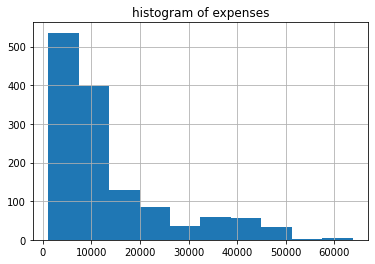

In [ ]:
# histogram of insurance expenses
insurance.expenses.hist()
plt.title("histogram of expenses")
plt.show()

expenses are right skewed with a mean of about 13k, and median 9.3k. 

In [ ]:
# correlations
insurance.corr()

,age,bmi,children,expenses
age,1.00,0.11,0.04,0.30
bmi,0.11,1.00,0.01,0.20
children,0.04,0.01,1.00,0.07
expenses,0.30,0.20,0.07,1.00


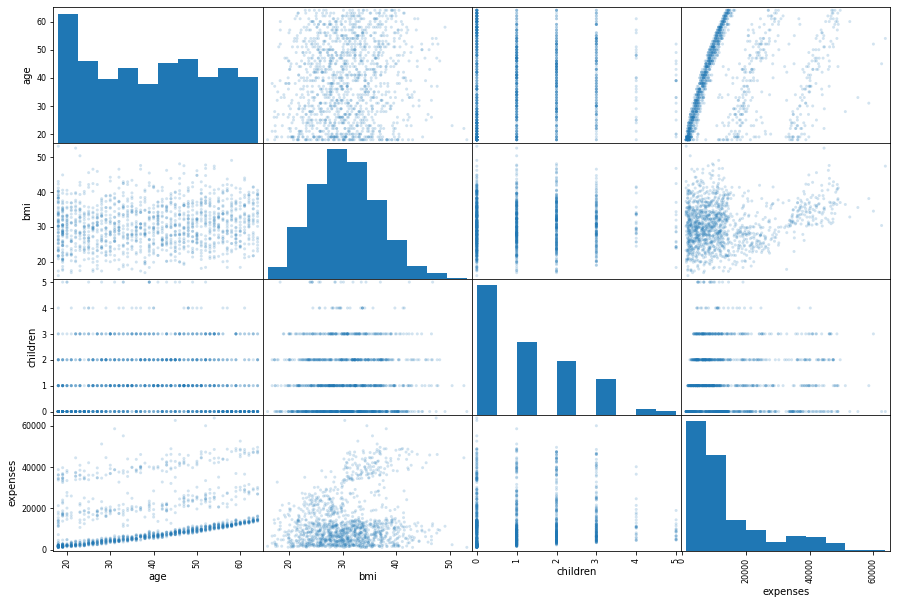

In [ ]:
# visualizing correlations
pd.plotting.scatter_matrix(insurance,figsize=(15, 10),alpha=0.2)
plt.show()

# 3 Building a base explanatory model on the whole data set

In [ ]:
# import the package (generally done above in a libraries section, demonstrated here for informational purposes)
from sklearn.linear_model import LinearRegression

dataset before dummy encoding

In [ ]:
insurance

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,30.97,3,no,northwest,10600.55
1334,18,female,31.92,0,no,northeast,2205.98
1335,18,female,36.85,0,no,southeast,1629.83
1336,21,female,25.80,0,no,southwest,2007.94


In [ ]:
#dataset after dummy encoding

In [ ]:
# dummy encode the dataframe
insurance_enc = pd.get_dummies(insurance,drop_first=True)
insurance_enc

,age,bmi,children,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.90,0,16884.92,0,1,0,0,1
1,18,33.77,1,1725.55,1,0,0,1,0
2,28,33.00,3,4449.46,1,0,0,1,0
3,33,22.70,0,21984.47,1,0,1,0,0
4,32,28.88,0,3866.86,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.97,3,10600.55,1,0,1,0,0
1334,18,31.92,0,2205.98,0,0,0,0,0
1335,18,36.85,0,1629.83,0,0,0,1,0
1336,21,25.80,0,2007.94,0,0,0,0,1


In [ ]:
# remove the target variable from our insurance_enc dataset and put it into a new variable, all in one command
y_target = insurance_enc.pop('expenses')

In [ ]:
# our target is a pandas series object
type(y_target)

pandas.core.series.Series

In [ ]:
# fit the model 
# no random state as there is no randomness to this classifier
# results are reproducible 

reg = LinearRegression().fit(insurance_enc,y_target)

In [ ]:
# score gives us R^2
reg.score(insurance_enc, y_target)

0.7509130345985207

In [ ]:
# coef represents the change in units of the target for every unit in the predictor 
reg.coef_

array([  256.85635254,   339.19345361,   475.50054515,  -131.3143594 ,
       23848.53454191,  -352.96389942, -1035.02204939,  -960.0509913 ])

In [ ]:
# make a nice dataframe so we can see the 
# predictors with their coefficients
pd.DataFrame({'column':insurance_enc.columns,'coef':reg.coef_})

,column,coef
0,age,256.86
1,bmi,339.19
2,children,475.50
3,sex_male,-131.31
4,smoker_yes,23848.53
5,region_northwest,-352.96
6,region_southeast,-1035.02
7,region_southwest,-960.05


In [ ]:
# show the intercept 
reg.intercept_

-11938.538576167142

# 4 Build a base predictive model and evaluate prediction performance

In [ ]:
scoring_list = ['neg_mean_absolute_error','neg_mean_absolute_percentage_error','neg_mean_squared_error','r2']

# save the scoring list so we don't have to code it each time for each cross validation

# 5 SLR cv training and testing 

In [ ]:
scores = cross_validate(
    LinearRegression(), 
    insurance_enc, 
    y_target, 
    cv=5, 
    scoring=scoring_list,
    return_train_score=True)

scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2
0,0.01,0.00,-4239.55,-4159.58,-0.42,-0.43,-37065146.66,-36415808.39,0.76,0.75
1,0.00,0.00,-4260.81,-4143.38,-0.42,-0.42,-38121880.55,-36166941.69,0.71,0.76
2,0.00,0.00,-4015.77,-4272.14,-0.45,-0.43,-32572832.89,-37576470.90,0.78,0.74
3,0.00,0.00,-4256.17,-4123.03,-0.41,-0.42,-39681281.46,-35742242.36,0.73,0.76
4,0.00,0.00,-4216.31,-4155.12,-0.42,-0.42,-37125506.89,-36381843.01,0.76,0.75


In [ ]:
scores_df.mean()

fit_time                                           0.00
score_time                                         0.00
test_neg_mean_absolute_error                   -4197.72
train_neg_mean_absolute_error                  -4170.65
test_neg_mean_absolute_percentage_error           -0.42
train_neg_mean_absolute_percentage_error          -0.42
test_neg_mean_squared_error                -36913329.69
train_neg_mean_squared_error               -36456661.27
test_r2                                            0.75
train_r2                                           0.75
dtype: float64

In [ ]:
scores_df.std()

fit_time                                         0.00
score_time                                       0.00
test_neg_mean_absolute_error                   103.19
train_neg_mean_absolute_error                   58.47
test_neg_mean_absolute_percentage_error          0.01
train_neg_mean_absolute_percentage_error         0.01
test_neg_mean_squared_error                2647174.54
train_neg_mean_squared_error                681096.94
test_r2                                          0.03
train_r2                                         0.01
dtype: float64

# 7 Visualize a Regression tree

we won't do cross validation here so that we can visualize the model

In [ ]:
# Regression tree
reg_tree = DecisionTreeRegressor(random_state=0,max_leaf_nodes=4)

In [ ]:
reg_tree = reg_tree.fit(insurance_enc,y_target)
reg_tree.get_n_leaves()

4

In [ ]:
from sklearn import tree
print(tree.export_text(reg_tree,feature_names=insurance_enc.columns.to_list()))

|--- smoker_yes <= 0.50
|   |--- age <= 42.50
|   |   |--- value: [5398.85]
|   |--- age >  42.50
|   |   |--- value: [12299.89]
|--- smoker_yes >  0.50
|   |--- bmi <= 30.01
|   |   |--- value: [21369.22]
|   |--- bmi >  30.01
|   |   |--- value: [41692.81]



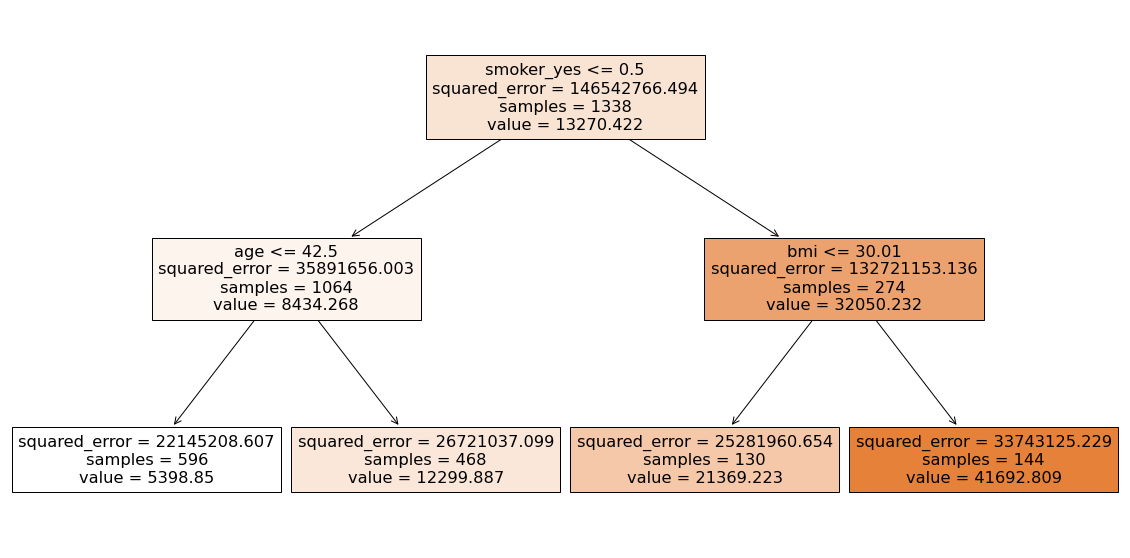

In [ ]:
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(reg_tree,
                   feature_names=insurance_enc.columns.to_list(), # make sure the feature names are in output
                   filled=True) # filled true color codes by the value of the continous target variable. higher number = more saturated 

# 8 Evaluate regression tree model

we'll let the model get a bit more complex to see how it compares against the linear regression model



In [ ]:
reg_tree_2 = DecisionTreeRegressor(random_state=0,max_leaf_nodes=400)

In [ ]:
scores = cross_validate(
    reg_tree_2, 
    insurance_enc, 
    y_target, 
    cv=5, 
    scoring=scoring_list,
    return_train_score=True)

scores_df = pd.DataFrame(scores)
scores_df.mean()

fit_time                                           0.01
score_time                                         0.00
test_neg_mean_absolute_error                   -3115.05
train_neg_mean_absolute_error                   -190.29
test_neg_mean_absolute_percentage_error           -0.36
train_neg_mean_absolute_percentage_error          -0.04
test_neg_mean_squared_error                -42723677.87
train_neg_mean_squared_error                 -202857.28
test_r2                                            0.71
train_r2                                           1.00
dtype: float64

clearly overfitting! back off the max leaf nodes

In [ ]:
reg_tree_3 = DecisionTreeRegressor(random_state=0,max_leaf_nodes=20)

In [ ]:
scores = cross_validate(
    reg_tree_3, 
    insurance_enc, 
    y_target, 
    cv=5, 
    scoring=scoring_list,
    return_train_score=True)

scores_df = pd.DataFrame(scores)
scores_df.mean()

fit_time                                           0.01
score_time                                         0.00
test_neg_mean_absolute_error                   -2783.03
train_neg_mean_absolute_error                  -2389.19
test_neg_mean_absolute_percentage_error           -0.32
train_neg_mean_absolute_percentage_error          -0.29
test_neg_mean_squared_error                -23981819.65
train_neg_mean_squared_error               -17536259.18
test_r2                                            0.83
train_r2                                           0.88
dtype: float64

we are overfitting a bit, but compare our MAPE and MAE metrics to the linear regression and you can see what are outperforming that model!

# 9 Improve lm model performance by adding interaction term for bmi and smoker. 

The interaction term models a more complex relationship between predictors and allows the model to see if there is a relationship between bmi and smoking status. 



In [ ]:
insurance_enc_new_terms = insurance_enc.copy()

In [ ]:
insurance_enc_new_terms['bmi*smoker'] = insurance_enc_new_terms.bmi*insurance_enc_new_terms.smoker_yes
insurance_enc_new_terms['bmi*smoker'][0:3]

0   27.90
1    0.00
2    0.00
Name: bmi*smoker, dtype: float64

In [ ]:
scores = cross_validate(
    LinearRegression(), 
    insurance_enc_new_terms, 
    y_target, 
    cv=5, 
    scoring=scoring_list,
    return_train_score=True)

scores_df = pd.DataFrame(scores)
scores_df.mean()

fit_time                                           0.00
score_time                                         0.00
test_neg_mean_absolute_error                   -2919.06
train_neg_mean_absolute_error                  -2897.69
test_neg_mean_absolute_percentage_error           -0.27
train_neg_mean_absolute_percentage_error          -0.27
test_neg_mean_squared_error                -23680617.50
train_neg_mean_squared_error               -23272282.51
test_r2                                            0.84
train_r2                                           0.84
dtype: float64

Wow! We've really improved our linear regression model here. Prior to this our model was performing poorly compared to our Tree model. 

In [ ]:
scores = cross_validate(
    reg_tree_3, 
    insurance_enc_new_terms, 
    y_target, 
    cv=5, 
    scoring=scoring_list,
    return_train_score=True)

scores_df = pd.DataFrame(scores)
scores_df.mean()

fit_time                                           0.01
score_time                                         0.00
test_neg_mean_absolute_error                   -2781.38
train_neg_mean_absolute_error                  -2433.49
test_neg_mean_absolute_percentage_error           -0.33
train_neg_mean_absolute_percentage_error          -0.30
test_neg_mean_squared_error                -23839788.88
train_neg_mean_squared_error               -17872711.65
test_r2                                            0.84
train_r2                                           0.88
dtype: float64

In [ ]:
# thank you for reading this notebook!

In [ ]:
!cp "/content/drive/My Drive/Colab Notebooks/6482_to_4482/Regression-and-regression-trees-insurance-tutorial.ipynb" ./

# run the second shell command, jupyter nbconvert --to html "file name of the notebook"
# create html from ipynb

!jupyter nbconvert --to html "Regression-and-regression-trees-insurance-tutorial.ipynb"

[NbConvertApp] Converting notebook Regression-and-regression-trees-insurance-tutorial.ipynb to html
[NbConvertApp] Writing 1647213 bytes to Regression-and-regression-trees-insurance-tutorial.html
